In [227]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr, spearmanr, pearsonr
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#import warnings
#warnings.filterwarnings('ignore')
data= pd.read_csv('data_train.csv')

In [145]:
data.head()

,Unnamed: 0,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,27239,34,Local-gov,144182,Preschool,1,Never-married,Adm-clerical,Own-child,Black,Female,0,0,25,United-States,<=50K
1,19102,20,Private,100605,HS-grad,9,Never-married,Sales,Own-child,Other,Male,0,0,40,Puerto-Rico,<=50K
2,16791,26,State-gov,152457,HS-grad,9,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,2832,57,Self-emp-not-inc,353808,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,60,United-States,>50K
4,8228,48,State-gov,122086,HS-grad,9,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,<=50K


In [159]:
n_records=data.shape[0]
n_greater_50k=data[data['label'] == ' >50K'].shape[0]
n_at_most_50k=data[data['label']==' <=50K'].shape[0]
greater_percent=(n_greater_50k / n_records)*100
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 29304
Individuals making more than $50,000: 7015
Individuals making at most $50,000: 22289
Percentage of individuals making more than $50,000: 23.938711438711437%


In [275]:
#Preprocesarea datelor
col_names=data.columns
num_data=data.shape[0]
for c in col_names:
    num_non=data[c].isin([" ?"]).sum()
    if num_non>0:
        print(c)
        print(num_non)
        print("{0:.2f}%".format(float(num_non) / num_data*100))
    

In [167]:
data=data[data["workclass"] != " ?"]
data=data[data["occupation"] != " ?"]
data=data[data["native-country"] != " ?"]
data.shape

(27146, 16)

In [174]:
#Normalizare
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
numerical=['age','education-num','capital-gain','capital-loss','hours-per-week']
features_log_transformed =data.drop('label', axis = 1)
features_log_minmax_transform=pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical]=scaler.fit_transform(features_log_transformed[numerical])
display(features_log_minmax_transform.head(n=5))


,Unnamed: 0,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,27239,0.232877,Local-gov,144182,Preschool,0.000000,Never-married,Adm-clerical,Own-child,Black,Female,0.0,0.0,0.244898,United-States
1,19102,0.041096,Private,100605,HS-grad,0.533333,Never-married,Sales,Own-child,Other,Male,0.0,0.0,0.397959,Puerto-Rico
2,16791,0.123288,State-gov,152457,HS-grad,0.533333,Never-married,Protective-serv,Not-in-family,White,Male,0.0,0.0,0.397959,United-States
3,2832,0.547945,Self-emp-not-inc,353808,Some-college,0.600000,Married-civ-spouse,Sales,Husband,White,Male,0.0,0.0,0.602041,United-States
4,8228,0.424658,State-gov,122086,HS-grad,0.533333,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,0.397959,United-States


In [212]:
#preprocesarea trasaturilor categorice
#trasaturile care nu sunt numerice sunt categorice, machine learning lucreaza cu valori numerice, deci, deci aceste trasaturi urmeaza a fi transformate
label_raw = data['label']
features_final=pd.get_dummies(features_log_minmax_transform)
label=label_raw.map({'<=50K':0,' >50K':1})
encoded=list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))
encoded

105 total features after one-hot encoding.


['Unnamed: 0',
 'age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'workclass_ Federal-gov',
 'workclass_ Local-gov',
 'workclass_ Private',
 'workclass_ Self-emp-inc',
 'workclass_ Self-emp-not-inc',
 'workclass_ State-gov',
 'workclass_ Without-pay',
 'education_ 10th',
 'education_ 11th',
 'education_ 12th',
 'education_ 1st-4th',
 'education_ 5th-6th',
 'education_ 7th-8th',
 'education_ 9th',
 'education_ Assoc-acdm',
 'education_ Assoc-voc',
 'education_ Bachelors',
 'education_ Doctorate',
 'education_ HS-grad',
 'education_ Masters',
 'education_ Preschool',
 'education_ Prof-school',
 'education_ Some-college',
 'marital-status_ Divorced',
 'marital-status_ Married-AF-spouse',
 'marital-status_ Married-civ-spouse',
 'marital-status_ Married-spouse-absent',
 'marital-status_ Never-married',
 'marital-status_ Separated',
 'marital-status_ Widowed',
 'occupation_ Adm-clerical',
 'occupation_ Armed-Forces',
 'occupation_ Craft-repair',
 'occu

In [245]:
#Selectarea trasaturilor

col_names=data.columns
param=[]
correlation=[]
abs_corr=[]
for c in col_names:
    if c != "label":
        if len(data[c].unique()) <=2:
            corr = spearmanr(data['label'],data[c])[0]
        else:
            corr=spearmanr(data['label'],data[c])[0]
        param.append(c)
        correlation.append(corr)
        abs_corr.append(abs(corr))
param_df=pd.DataFrame({'correlation':correlation, 'parameter':param, 'abs_corr':abs_corr})
param_df=param_df.sort_values(by=['abs_corr'],ascending=False)
param_df=param_df.set_index('parameter')
param_df

,correlation,abs_corr
parameter,,
relationship,-0.335142,0.335142
education-num,0.329213,0.329213
capital-gain,0.277641,0.277641
age,0.276119,0.276119
hours-per-week,0.268819,0.268819
marital-status,-0.228318,0.228318
sex,0.218023,0.218023
capital-loss,0.142025,0.142025
race,0.080517,0.080517


In [300]:
best_features=param_df.index[0:8].values
print('Best features:\t',best_features)

Best features:	 ['relationship' 'education-num' 'capital-gain' 'age' 'hours-per-week'
 'marital-status' 'sex' 'capital-loss']


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028387B25A08>,
      dtype=object)

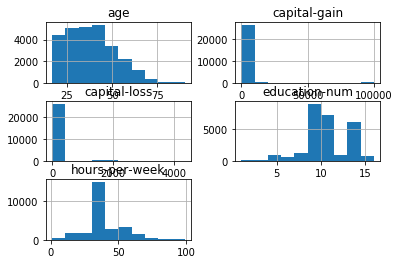

In [301]:
data[['relationship','education-num','capital-gain','age','hours-per-week','marital-status','sex','capital-loss']].hist() 

In [ ]:
#observam ca ne-a facut plot doar la valorile numerice cele mai semnificative, acestea fiind:
#age, capital-gain, capital-loss, education-num, hours-per-week

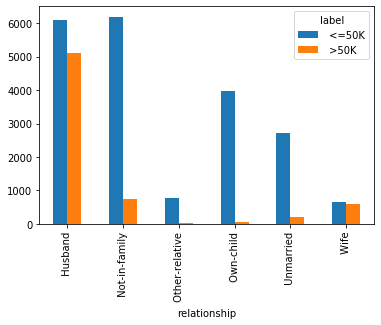

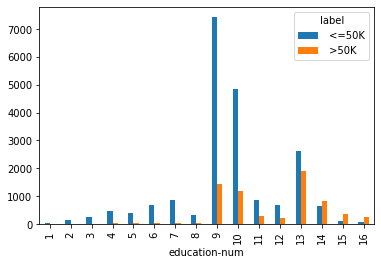

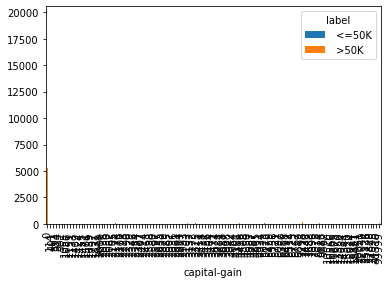

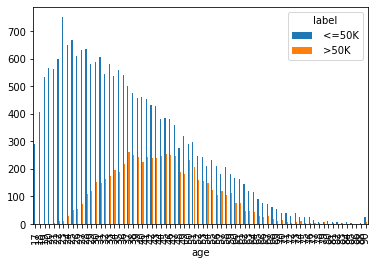

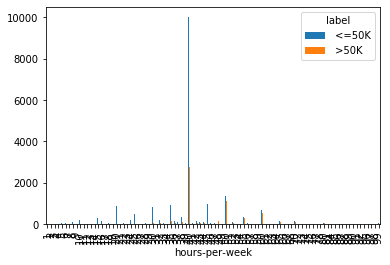

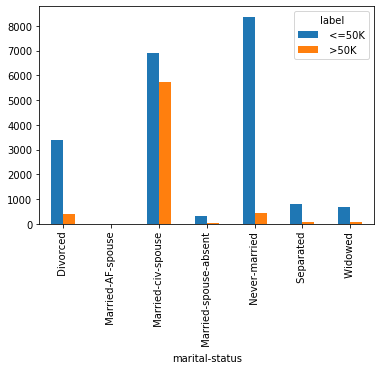

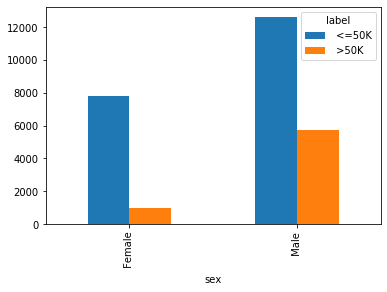

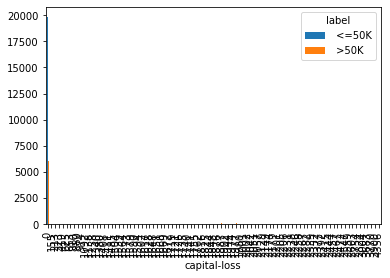

In [322]:
col=["relationship","education-num", "capital-gain",
      "age","hours-per-week","marital-status", "sex", "capital-loss"]
for x in col:
    pd.crosstab(data[x],data.label).plot(kind='bar')
plt.show()

In [251]:
#splitting the data
#we split 80% to training and 20% for testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(features_final, label, test_size=0.2, random_state=0)
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 21716 samples.
Testing set has 5430 samples.


In [298]:

TP = np.sum(label) 
# Specific to the naive case
FP = label.count() - TP
# No predicted negatives in the naive case
TN = 0 
FN = 0 

# Calculate accuracy, precision and recall
accuracy = TP / (TP + FP + TN + FN)
recall = TP / (TP + FN)
precision = TP / (TP + FP)

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta = 0.5
fscore = (1 + beta**2) * ((precision * recall) / ((beta**2) * precision + recall))

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 1.0000, F-score: 1.0000]


In [ ]:
# Import functionality for cloning a model
from sklearn.base import clone

from sklearn.ensemble import AdaBoostClassifier 
model = AdaBoostClassifier().fit(X_train, y_train)
# Reduce the feature space
importances = model.feature_importances_
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

In [ ]:
#logistic regresion
from sklearn.linear_model import LogisticRegression
logistic=LogisticRegression(solver='newton-cg')
logistic.fit(X_train,y_train)
y_pred_logistic=logistic.predict(X_test)
y_train_score_logistic=logistic.predict(X_train)
print("accuracy of the model is:\nTest ",accuracy_score(y_test, y_pred_logistic, normalize=False, sample_weight=None))
print('Train', accuracy_score(y_train_score_logistic,normalize=False, sample_weight=None))

In [276]:

print(data.std())

age                   13.137119
fnlwgt            106147.491429
education-num          2.546444
capital-gain        7404.405497
capital-loss         404.427244
hours-per-week        11.990773
dtype: float64


In [ ]:
#Asadar, eu in plan am scris ca se poate face cu PCA, dar tinand cont ca in baza noastra de date avem si variabile ce nu sunt numerice, dar sunt semnificative in realizarea predictiei, m-am reorientat.
#Mai sus, am reusit sa identific trasaturile cele mai reprezentative.
#O recomandare pentru a-i face pe cei care castiga mai putin sa isi mareasca venitul anual ar fi sa creasca numarul anilor de studiu, lucru ce poate fi observat si din barchart.         